Radius for desired 0-Dimensional Holes: 0.6355299999997425
Number of 0-dimensional holes after filtration: 600


C:\Users\Sudarshan Gogoi\anaconda3\lib\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


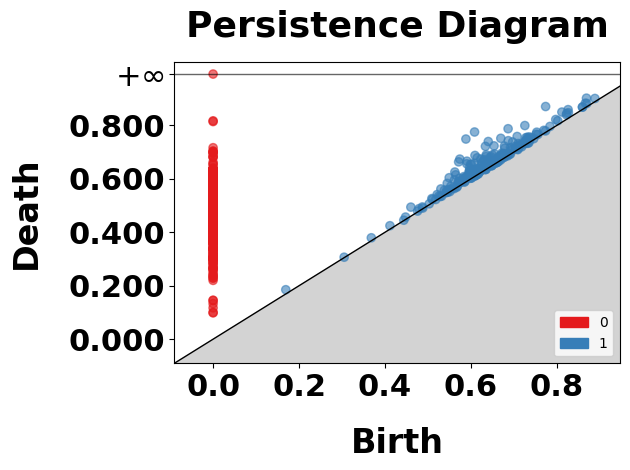

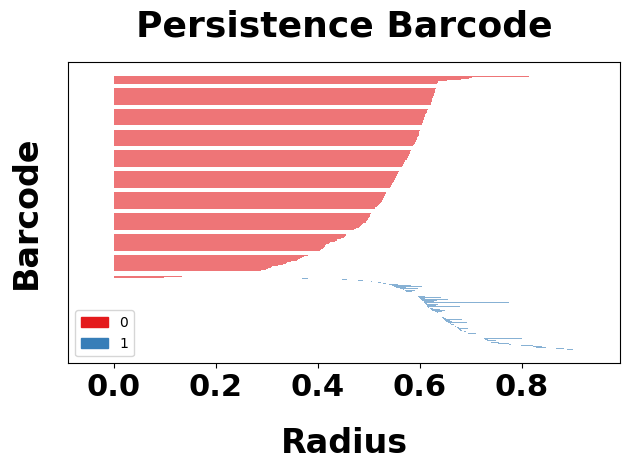

C:\Users\Sudarshan Gogoi\AppData\Local\Temp\ipykernel_18592\2886836836.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  polygon = plt.Polygon(points, color='lightblue', alpha=0.6,


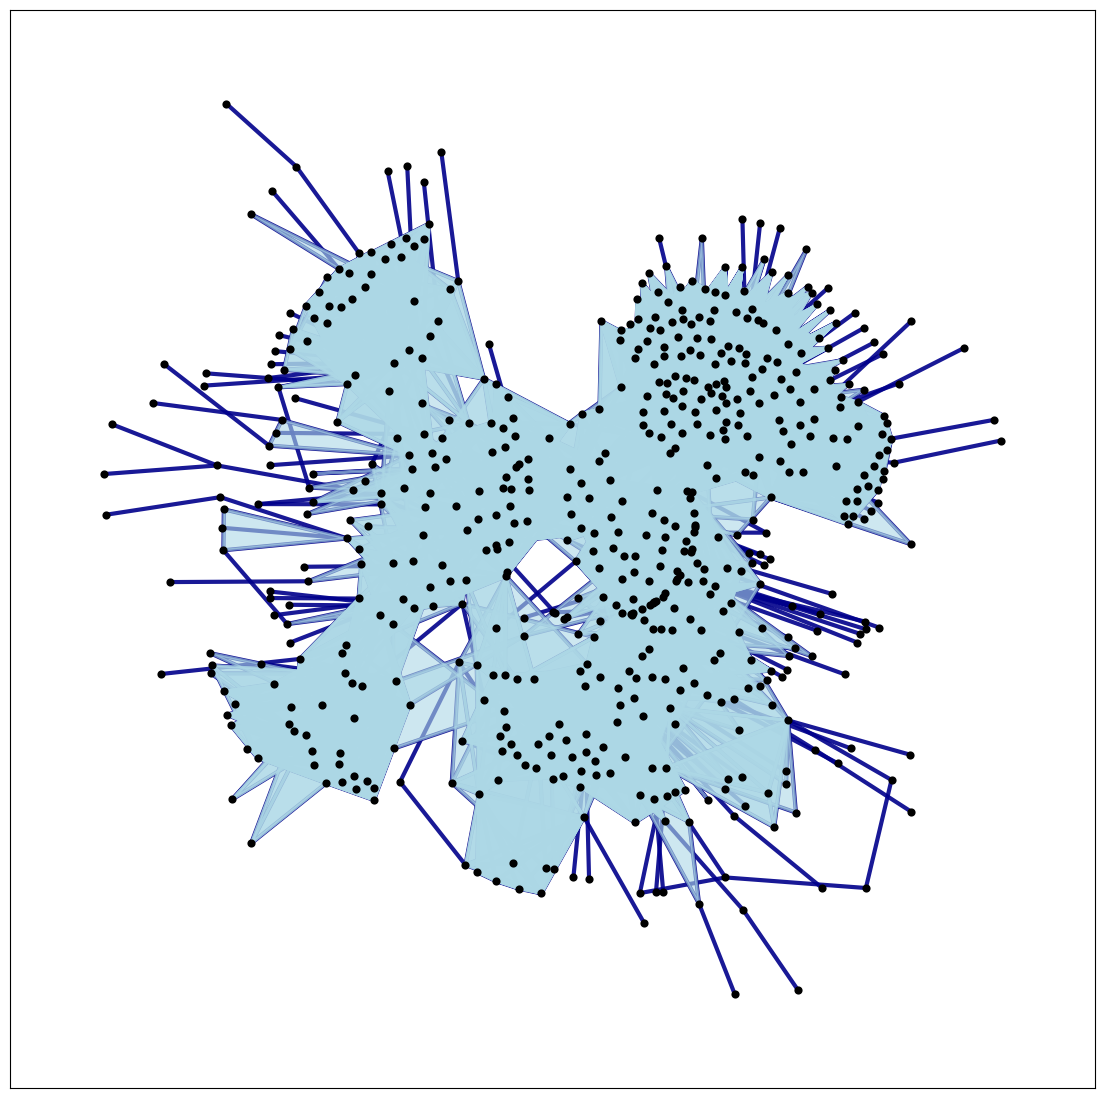

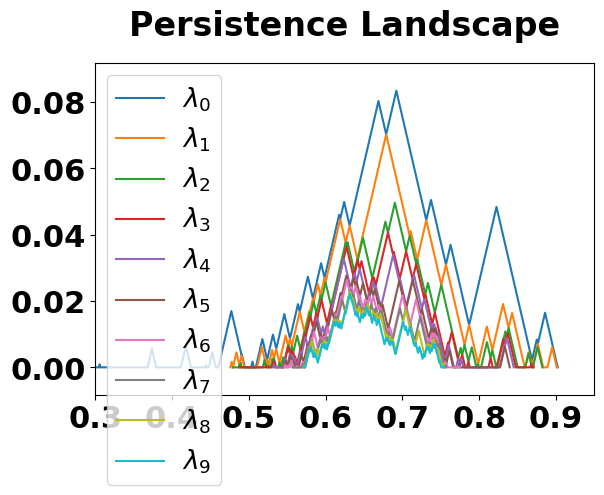

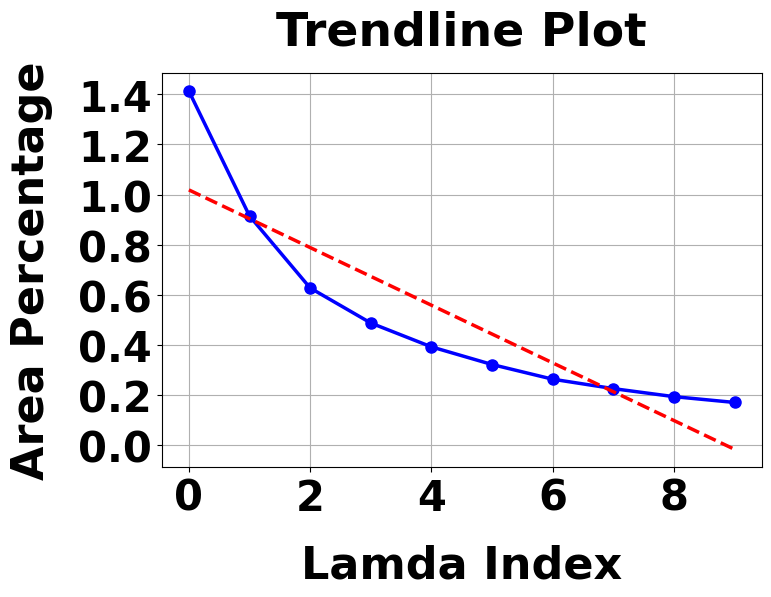

Predicted cancer types and similarities saved to D:/My PhD information folder second paper/Paper2DatasetsAnalysis/FunctionTest/ClassificationResults.xlsx

Results:
  Top 1 Prediction  Top 1 Similarity (%) Top 2 Prediction  \
0           Breast             93.829348       Colorectal   

   Top 2 Similarity (%) Most_Similar_Cancer Prostate Cancer  
0             88.709074              Breast        Negative  


In [1]:
# Install required packages only if not already installed
import subprocess
import sys

required_packages = {
    "pandas": "pandas", 
    "numpy": "numpy", 
    "matplotlib": "matplotlib", 
    "gudhi": "gudhi", 
    "persim": "persim", 
    "scipy": "scipy", 
    "networkx": "networkx"
}

for module_name, package_name in required_packages.items():
    try:
        __import__(module_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# Now import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi
import csv
from persim import PersLandscapeExact
from persim.landscapes import plot_landscape_simple
from scipy.stats import linregress
import networkx as nx

def Topological_Classification(input_csv_path, output_directory, desired_num_holes=600, max_lambda=10):
    """
    Perform complete topological analysis and classification pipeline.
    
    Parameters:
    - input_csv_path: Path to the input correlation matrix CSV file
    - output_directory: Directory to save all output files
    - desired_num_holes: Desired number of 0-dimensional holes for filtration (default: 600)
    - max_lambda: Maximum number of lambda values for persistence landscape (default: 10)
    
    Returns:
    DataFrame: Classification results with predictions and similarity scores
    """
    
    # ------------------------- Helper Functions -------------------------
    
    def calculate_area(critical_pairs):
        critical_pairs = sorted(critical_pairs, key=lambda pair: pair[0])
        area = 0.0
        for i in range(1, len(critical_pairs)):
            x0, y0 = critical_pairs[i-1]
            x1, y1 = critical_pairs[i]
            area += (x1 - x0) * (y0 + y1) / 2.0
        return area
    
    def extract_simplicial_complex_at_threshold(simplex_tree, threshold):
        simplicial_complex = []
        for simplex, filtration in simplex_tree.get_skeleton(2):
            if filtration <= threshold:
                simplicial_complex.append(simplex)
        return simplicial_complex
    
    def visualize_simplicial_complex(simplicial_complex, output_path):
        G = nx.Graph()
        
        for simplex in simplicial_complex:
            if len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])

        num_nodes = len(G.nodes)
        num_edges = len(G.edges)
        num_triangles = sum(1 for simplex in simplicial_complex if len(simplex) == 3)
        
        data = {
            'Metric': ['Nodes', 'Edges', 'Triangles'],
            'Count': [num_nodes, num_edges, num_triangles]
        }
        pd.DataFrame(data).to_csv(f"{output_path}/simplicial_complex_data.csv", index=False)
        
        plt.figure(figsize=(14, 14))
        pos = nx.kamada_kawai_layout(G)
        
        nx.draw_networkx_nodes(G, pos, node_size=15, node_color='black', 
                              edgecolors='k', linewidths=2)
        nx.draw_networkx_edges(G, pos, width=3, edge_color='darkblue', alpha=0.9)
        
        for simplex in simplicial_complex:
            if len(simplex) == 3:
                try:
                    points = [pos[node] for node in simplex]
                    polygon = plt.Polygon(points, color='lightblue', alpha=0.6, 
                                        edgecolor='darkblue', linewidth=2)
                    plt.gca().add_patch(polygon)
                except KeyError as e:
                    print(f"Warning: Node {e} not found in position dictionary.")
                    
        plt.savefig(f"{output_path}/simplicial_complex_plot.png", dpi=300, 
                   bbox_inches='tight', format='png')
        plt.show(block=True)
    
    def get_radius_filtered_matrix_and_genes(persistence1, distance_matrix_np, df_1, output_directory, desired_num_holes):
        finite_persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence1 if death != float('inf')]
        zero_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 0]
        
        intervals_less_than = {}
        for i in range(21):
            radius = i * 0.1
            intervals_less_than[radius] = sum(1 for birth, death in zero_dim_holes if (death - birth) < radius)
        
        radiuses = list(intervals_less_than.keys())
        hole_counts = list(intervals_less_than.values())
        
        plt.figure(figsize=(15, 10), dpi=600)
        plt.plot(radiuses, hole_counts, marker='o', markersize=12, linestyle='-', linewidth=4)
        plt.xlabel('Radius', fontsize=40, fontweight='bold', labelpad=18)
        plt.ylabel('Number of 0-Dimensional Holes', fontsize=36, fontweight='bold', labelpad=18)
        plt.grid(True)
        plt.xticks(fontsize=37, fontweight='bold')
        plt.yticks(fontsize=37, fontweight='bold')
        plt.title("0-th Betti Numbers Plot", fontsize=44, fontweight='bold', pad=18)
        plt.xticks(radiuses)
        plt.yticks(range(0, max(hole_counts) + 200, 200))
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.savefig(f"{output_directory}/0-th Betti Numbers Plot.png", bbox_inches='tight', dpi=300)
        plt.show()
        
        radius_life_range = 0.0
        while True:
            num_holes = sum(1 for birth, death in zero_dim_holes if (death - birth) <= radius_life_range)
            if num_holes >= desired_num_holes:
                break
            radius_life_range += 0.00001
        
        print("Radius for desired 0-Dimensional Holes:", radius_life_range)
        filtered_bars = [bar for bar in persistence1 if bar[1][1] - bar[1][0] <= radius_life_range]
        print("Number of 0-dimensional holes after filtration:", len(filtered_bars))
        
        rows_to_keep = [i for i, row in enumerate(distance_matrix_np) if np.any((row < radius_life_range) & (row != 0))]
        cols_to_keep = [i for i, col in enumerate(distance_matrix_np.T) if np.any((col < radius_life_range) & (col != 0))]
        
        filtered_distance_matrix_np = distance_matrix_np[np.ix_(rows_to_keep, cols_to_keep)]
        filtered_distance_matrix_df = pd.DataFrame(
            filtered_distance_matrix_np,
            index=df_1.index[rows_to_keep],
            columns=df_1.columns[cols_to_keep]
        )
        
        filtered_distance_matrix_df.to_csv(f"{output_directory}/FilteredDistanceMatrix.csv")
        significant_genes = pd.DataFrame(filtered_distance_matrix_df.index, columns=['Significant Genes'])
        significant_genes.to_csv(f"{output_directory}/SignificantGenes.csv", index=False)
        
        return radius_life_range, filtered_distance_matrix_np, filtered_distance_matrix_df
    
    def classification_model1(features_dict, output_directory):
        df = pd.DataFrame([features_dict])
        
        df = df.rename(columns={
            '0-Dimensional Hole Minimum Life Range': '0-Dim Hole Min Life Range',
            '0-Dimensional Hole Maximum Life Range': '0-Dim Hole Max Life Range',
            'Range of Death Values for 0-Dimensional Holes': 'Range of Death for 0-Dim Holes',
            '1-Dimensional Hole Maximum Life Range': '1-Dim Hole Max Life Range',
            'Average Birth (1D)': 'Average Birth (1D)',
            'Average Death (1D)': 'Average Death (1D)',
            'Slope': 'Slope',
            'Intercept': 'Intercept',
            'R^2': 'R^2',
            'Radius_Life_Range': 'Radius_Life_Range',
            'Nodes': 'Nodes',
            'Edges': 'Edges',
            'Triangles': 'Triangles'
        })
        
        reference_points_9d = {
            'Breast': [0.157743567, 0.818611422, 0.660867855, 0.155821208, 0.700137783, 0.724067464, -0.102958566, 0.882012571, 0.764028453],
            'Lung': [0.06481658, 0.785079086, 0.720262505, 0.189788118, 0.588305507, 0.616069215, -0.183296104, 1.415417141, 0.715229759],
            'Colorectal': [0.05106091, 0.783812814, 0.732751904, 0.159263131, 0.519388215, 0.544661586, -0.119072507, 0.810484744, 0.578746547],
            'Ovarian': [0.045013986, 0.692543712, 0.647529727, 0.118948963, 0.527493781, 0.546090125, -0.027696076, 0.177829171, 0.343875139],
            'Prostate': [0.095780343, 0.77870621, 0.682925867, 0.197063307, 0.636666732, 0.667462428, -0.169148461, 1.707644312, 0.777742912]
        }
        
        reference_points_1d = {
            "Breast": 0.686710619,
            "Lung": 0.516104,
            "Colorectal": 0.473829375,
            "Ovarian": 0.597834333331079,
            "Prostate": 0.584905531
        }
        
        features_9d = [
            '0-Dim Hole Min Life Range', '0-Dim Hole Max Life Range', 'Range of Death for 0-Dim Holes',
            '1-Dim Hole Max Life Range', 'Average Birth (1D)', 'Average Death (1D)', 'Slope', 'Intercept', 'R^2'
        ]
        
        def calculate_similarity_9d(row):
            similarities = {}
            for cancer_type, ref_values in reference_points_9d.items():
                ed = np.sqrt(sum((row[feature] - ref_value) ** 2 for feature, ref_value in zip(features_9d, ref_values)))
                max_ed = np.sqrt(sum((1 - 0) ** 2 for _ in range(len(features_9d))))
                similarity = 100 - (ed / max_ed * 100)
                similarities[cancer_type] = similarity

            sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

            for i, (cancer_type, similarity) in enumerate(sorted_similarities[:2]):
                row[f'Top {i+1} Prediction'] = cancer_type
                row[f'Top {i+1} Similarity (%)'] = similarity
            return row
        
        df = df.apply(calculate_similarity_9d, axis=1)
        
        def calculate_similarity_1d(value1, value2):
            return (1 - abs(value1 - value2) / max(value1, value2)) * 100
        
        def get_highest_similarity(row):
            radius_life_range = row['Radius_Life_Range']
            
            if pd.isna(radius_life_range):
                return None
            
            top1 = row['Top 1 Prediction']
            top2 = row['Top 2 Prediction']
            
            cancers_to_compare = [top1, top2]
            
            highest_similarity = -1
            most_similar_cancer = None
            
            for cancer in cancers_to_compare:
                if cancer in reference_points_1d:
                    similarity = calculate_similarity_1d(radius_life_range, reference_points_1d[cancer])
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_cancer = cancer
            
            return most_similar_cancer
        
        df['Most_Similar_Cancer'] = df.apply(get_highest_similarity, axis=1)
        return df
    
    def classification_model2(df, output_directory):
        df = df.loc[:, ~df.columns.astype(str).str.contains('^Unnamed')]
        
        df['EulerCharacteristic'] = df['Nodes'] - df['Edges'] + df['Triangles']
        df['EulerCharacteristic_Normalized'] = np.log(np.abs(df['EulerCharacteristic']) + 1)
        
        threshold = 10.78
        df['Prostate Cancer'] = df['EulerCharacteristic_Normalized'].apply(
            lambda x: 'Positive' if x < threshold else 'Negative'
        )
        
        return df
    
    # ------------------------- Main Analysis Pipeline -------------------------
    
    # Step 1: Read and process input data
    df_1 = pd.read_csv(input_csv_path, index_col=0)
    distance_matrix = 1 - np.abs(df_1)
    distance_matrix_np = distance_matrix.values
    
    # Step 2: Construct initial simplicial complex and compute persistence
    rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix_np)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    persistence1 = simplex_tree.persistence()
    
    # Step 3: Get radius, filtered matrix, and significant genes
    radius_life_range, filtered_distance_matrix_np, filtered_distance_matrix_df = get_radius_filtered_matrix_and_genes(
        persistence1, distance_matrix_np, df_1, output_directory, desired_num_holes
    )
    
    # Step 4: Compute persistence for dimension 2
    rips_complex = gudhi.RipsComplex(distance_matrix=filtered_distance_matrix_np)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence2 = simplex_tree.persistence()
    
    # Plot persistence diagram
    gudhi.plot_persistence_diagram(persistence2)
    plt.xlabel("Birth", fontsize=24, fontweight='bold', labelpad=18)
    plt.ylabel("Death", fontsize=24, fontweight='bold', labelpad=18)
    plt.xticks(fontsize=22, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.title("Persistence Diagram", fontsize=26, fontweight='bold', pad=18)
    plt.tight_layout()
    plt.savefig(f"{output_directory}/Persistence Diagram.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Plot persistence barcode
    gudhi.plot_persistence_barcode(persistence2)
    plt.xlabel("Radius", fontsize=24, fontweight='bold', labelpad=18)
    plt.ylabel("Barcode", fontsize=24, fontweight='bold', labelpad=18)
    plt.xticks(fontsize=22, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.title("Persistence Barcode", fontsize=26, fontweight='bold', pad=18)
    plt.tight_layout()
    plt.savefig(f"{output_directory}/Persistence Barcode.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    # Step 5: Analyze simplicial complex
    simplicial_complex_at_a = extract_simplicial_complex_at_threshold(simplex_tree, radius_life_range)
    if len(simplicial_complex_at_a) == 0:
        print("\u26A0\ufe0f No simplices exist at this threshold!")
    else:
        visualize_simplicial_complex(simplicial_complex_at_a, output_directory)
    
    # Step 6: Compute feature vector 1
    finite_persistence = [(dim, (birth, death)) for dim, (birth, death) in persistence2 if death != float('inf')]
    zero_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 0]
    one_dim_holes = [(birth, death) for dim, (birth, death) in finite_persistence if dim == 1]
    
    min_life_range_0D = min(death - birth for birth, death in zero_dim_holes)
    max_life_range_0D = max(death - birth for birth, death in zero_dim_holes)
    range_death_0D = max(death for _, death in zero_dim_holes) - min(death for _, death in zero_dim_holes)
    
    birth_values_1D = [birth for birth, _ in one_dim_holes]
    death_values_1D = [death for _, death in one_dim_holes]
    max_life_range_1D = max(death - birth for birth, death in one_dim_holes) if one_dim_holes else 0
    avg_birth_1D = np.mean(birth_values_1D) if birth_values_1D else 0
    avg_death_1D = np.mean(death_values_1D) if death_values_1D else 0
    
    feature_vector1 = [
        ["0-Dimensional Hole Minimum Life Range", min_life_range_0D],
        ["0-Dimensional Hole Maximum Life Range", max_life_range_0D],
        ["Range of Death Values for 0-Dimensional Holes", range_death_0D],
        ["1-Dimensional Hole Maximum Life Range", max_life_range_1D],
        ["Average Birth (1D)", avg_birth_1D],
        ["Average Death (1D)", avg_death_1D],
    ]
    
    with open(f"{output_directory}/feature_vector1.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Feature", "Value"])
        writer.writerows(feature_vector1)
    
    # Step 7: Create persistence landscapes
    dim0 = []
    dim1 = []
    
    for d, (birth, death) in persistence2:
        if d == 0:
            dim0.append([birth, death])
        elif d == 1:
            dim1.append([birth, death])
    
    pd_dgms = [np.array(dim0), np.array(dim1)]
    ple1 = PersLandscapeExact(dgms=pd_dgms, hom_deg=1)
    
    critical_pairs = ple1.critical_pairs[:max_lambda]
    ple_partial = PersLandscapeExact(critical_pairs=critical_pairs)
    plot_landscape_simple(ple_partial)
    plt.xlim(0.3, 0.95)
    plt.title("Persistence Landscape", fontsize=24, fontweight='bold', pad=20)
    plt.yticks(fontsize=22, fontweight='bold')
    plt.xticks(fontsize=22, fontweight='bold')
    plt.tight_layout(pad=2.0)
    leg = plt.legend(loc='upper left', fontsize=17)
    for text in leg.get_texts():
        text.set_fontsize(19)
        text.set_fontweight('bold')
    plt.savefig(f'{output_directory}/landscape_plot.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    # Step 8: Compute persistence landscape areas and trendline
    areas_lambda = {}
    for i in range(max_lambda):
        if i < len(ple1.critical_pairs) and ple1.critical_pairs[i] is not None:
            critical_pairs = ple1.critical_pairs[i]
            area = calculate_area(critical_pairs)
            areas_lambda[f"lambda_{i}"] = area
        else:
            areas_lambda[f"lambda_{i}"] = 0.0
    
    with open(f"{output_directory}/LandscapeAreas.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Lambda", "Area", "Area (%)"])
        for i in range(len(areas_lambda)):
            area = areas_lambda[f"lambda_{i}"]
            writer.writerow([f"lambda_{i}", area, area * 100])
    
    areas_df = pd.read_csv(f"{output_directory}/LandscapeAreas.csv")
    column_name = 'Area (%)'
    
    if column_name in areas_df.columns and len(areas_df[column_name].unique()) > 1:
        x = np.arange(len(areas_df))
        y = areas_df[column_name]
        
        plt.figure(figsize=(8, 6.5))
        plt.plot(x, y, marker='o', markersize=8, linestyle='-', color='b', linewidth=2.5)
        plt.xlabel('Lamda Index', fontsize=32, fontweight='bold', labelpad=18)
        plt.ylabel('Area Percentage', fontsize=32, fontweight='bold', labelpad=18)
        plt.title('Trendline Plot', fontsize=34, fontweight='bold', pad=21)
        plt.tight_layout(pad=3.6)
        plt.yticks(fontsize=30, fontweight='bold')
        plt.xticks(fontsize=30, fontweight='bold')
        plt.grid(True)
        
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        trend_line = slope * x + intercept
        plt.plot(x, trend_line, color='r', linestyle='--', linewidth=2.5)
        
        r_squared = r_value ** 2
        equation = f'y = {slope:.4f}x + {intercept:.4f}'
        
        plt.savefig(f"{output_directory}/TrendlinePlot.png", bbox_inches='tight', dpi=300)
        plt.show()
        
        with open(f"{output_directory}/TrendlineDetails.csv", mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Slope", "Intercept", "R^2", "Equation"])
            writer.writerow([slope, intercept, r_squared, equation])
    
    # Step 9: Load all features for classification
    def load_features(output_directory):
        feature_vector1 = pd.read_csv(f"{output_directory}/feature_vector1.csv")
        features_dict = dict(zip(feature_vector1['Feature'], feature_vector1['Value']))
        
        trendline_details = pd.read_csv(f"{output_directory}/TrendlineDetails.csv")
        features_dict.update({
            'Slope': trendline_details['Slope'].values[0],
            'Intercept': trendline_details['Intercept'].values[0],
            'R^2': trendline_details['R^2'].values[0]
        })
        
        try:
            sc_data = pd.read_csv(f"{output_directory}/simplicial_complex_data.csv")
            features_dict.update({
                'Radius_Life_Range': radius_life_range,
                'Nodes': sc_data.loc[sc_data['Metric'] == 'Nodes', 'Count'].values[0],
                'Edges': sc_data.loc[sc_data['Metric'] == 'Edges', 'Count'].values[0],
                'Triangles': sc_data.loc[sc_data['Metric'] == 'Triangles', 'Count'].values[0]
            })
        except:
            features_dict.update({
                'Radius_Life_Range': radius_life_range,
                'Nodes': np.nan,
                'Edges': np.nan,
                'Triangles': np.nan
            })
        
        return features_dict
    
    features_dict = load_features(output_directory)
    
    # Step 10: Perform classification
    results = classification_model1(features_dict, output_directory)
    results = classification_model2(results, output_directory)
    
    # Save final results
    output_file = f"{output_directory}/ClassificationResults.xlsx"
    results.to_excel(output_file, index=False)
    
    print(f"Predicted cancer types and similarities saved to {output_file}")
    print("\nResults:")
    print(results[['Top 1 Prediction', 'Top 1 Similarity (%)', 
                  'Top 2 Prediction', 'Top 2 Similarity (%)',
                  'Most_Similar_Cancer', 'Prostate Cancer']])
    
    return results

# Example usage:
results = Topological_Classification(
    input_csv_path='D:/My PhD information folder second paper/Paper2DatasetsAnalysis/FunctionTest/CancerCorrMat.csv',
    output_directory='D:/My PhD information folder second paper/Paper2DatasetsAnalysis/FunctionTest',
    desired_num_holes=600,
    max_lambda=10
)